In [33]:
import uproot
from pylab import *
import pandas as pd
import utility_common as common
from utility_dfplotter import *  

In [34]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


        
    
class DFGetter():
    def __init__(self, rootFile, selection, name):
        self.f = uproot.open(rootFile)
        self.selection = selection
        self.name = name
        self._get_name_list()
        
        
    def get(self, features, slt):
        df = pd.DataFrame()
        for tName in self.tNameList:
            tree =  self.f[self.selection+'/bltTree_'+tName]
            temp = tree.pandas.df(features, namedecode="utf-8")
        
            sf = self._get_scale_factor_to_lumin(tName)
            temp['eventWeight'] = temp.eventWeight*sf
            temp = temp.query(slt)
            if "nJets>=4" in slt:
                temp['leptonOneMetMt'] = (2*temp.leptonOnePt*temp.met*(1-np.cos(temp.leptonOnePhi-temp.metPhi )))**0.5 
            temp['leptonOneMetDeltaPhi'] = np.arccos(np.cos(temp.leptonOnePhi-temp.metPhi))
            temp['leptonOneHtDeltaPhi'] = np.arccos(np.cos(temp.leptonOnePhi-temp.htPhi))
            df = pd.concat([df, temp])
                
                
        return df
    
    def _get_scale_factor_to_lumin(self, tName, lumin=35.864):
        xs = common.get_cross_section(tName)
        
        if xs:

            histogram = self.f['TotalEvents_'+tName]
            histogram = histogram.allvalues

            nGenTotal = histogram[1] - 2*histogram[10]
            # calculate SF to lumin
            scaleFactor = lumin * xs/nGenTotal
            return scaleFactor
        else:
            return 1.0
            
            
    def _get_name_list(self):
        ## 1. define the datalist
        if self.name == 'data':
            if self.selection in ['mu']:
                self.tNameList = ['muon_2016'+str(p) for p in "BCDEFGH"]

            if self.selection in ['e']:
                self.tNameList = ['electron_2016'+str(p) for p in "BCDEFGH"]

        ## 2. define the MC list
        if self.name == 'vv': self.tNameList = [ 'ww','wz_2l2q','wz_3lnu','zz_2l2nu','zz_2l2q','zz_4l']
        if self.name == 'z':  self.tNameList = [ 'zjets_m-10to50_amcatnlo','zjets_m-50_amcatnlo']
        if self.name == 'w':  self.tNameList = [ 'w1jets','w2jets','w3jets','w4jets' ]
        if self.name == 't':  self.tNameList = [ 'ttbar_inclusive','t_tw','tbar_tw','t_t','tbar_t']
        if self.name == 'g':  self.tNameList = [ 'gjets_ht40to100','gjets_ht100to200','gjets_ht200to400','gjets_ht400to600','gjets_ht600toinf']

In [35]:
def makePlots(selection,isoPass):
    fileName  = "../../data/root/Run2016_Singlelep_20200712.root"

    features  = ['eventWeight','leptonOneIso','leptonOnePt','leptonOneEta','leptonOnePhi','leptonOneIsoPass','leptonOneMetMt','nJets','nBJets','met','metPhi','htPhi']
    slt = slt_jet + "&leptonOneIsoPass=="+str(isoPass)
    
    data = DFGetter(fileName,selection,'data').get(features,slt)
    mcg  = DFGetter(fileName,selection,'g').get(features,slt)
    mct  = DFGetter(fileName,selection,'t').get(features,slt)
    mcw  = DFGetter(fileName,selection,'w').get(features,slt)
    mcz  = DFGetter(fileName,selection,'z').get(features,slt)
    mcvv = DFGetter(fileName,selection,'vv').get(features,slt)
    dfList   = [mcvv,mcz,mcw,mct,mcg,data]


    configs = [
        ('leptonOneIso', 0, 0.31, 0.01, 'leptonOneIso'),
        ('leptonOnePt', 20, 160, 5, 'leptonOnePt'),
        ('leptonOneEta', -4, 4, 0.1, 'leptonOneEta'),
        ('leptonOneMetMt', 0, 160, 5, 'leptonOneMetMt'),
        ('leptonOneMetDeltaPhi', 0, 3.2, 0.1, 'leptonOneMetDeltaPhi'),
        ('leptonOneHtDeltaPhi', 0, 3.2, 0.1, 'leptonOneHtDeltaPhi'),
        ('nJets', 0, 10, 1, 'nJets'),
        ('nBJets', 0, 10, 1, 'nBJets'),
        ('met', 0, 120, 5, 'met')
    ]

    legends  = ['VV','Z','W',"t", r"$\gamma$", "data"]
    colors   = ["C0", "C1", "C3","C2","C4",'k']
    if selection == "mu":
        subtitle = r"$\mu$ channel, "
    else:
        subtitle = r"$e$ channel, "

    subtitle += slt_subtitle

    if isoPass:
        subtitle2 = "$Tight$-iso"
    else:
        subtitle2 = r"$\overline{Tight}$-iso" 


    nqcd,nvarqcd = 0,0
    legendsAdd = []
    for i in range(len(dfList)):
        n = dfList[i].eventWeight.sum()
        nvar = sum(dfList[i].eventWeight**2)
        string = "{:.0f}".format(n)+r"$\pm$"+"{:.0f}".format(nvar**0.5)

        print(string)
        legendsAdd.append(string)

        if i < len(dfList)-1:
            nqcd -= n
            nvarqcd += (0.1*n)**2
        else:
            nqcd += n
        nvarqcd += nvar

    string = "{:,.0f}".format(nqcd)+r"$\pm$"+"{:,.0f}".format(nvarqcd**0.5) 
    print(string)
    legendsAdd.append(string)

    legends2 = [legends[i]+": "+legendsAdd[i] for i in range(len(legends))]


    for config in configs:
        v,a,b,step,xl = config

        sk = ASingleKinematicPlot(v,a,b,step,dfList)
        sk.settingPlot(xl,legends2,colors,period='2016',withXsErr=True)
        sk.makePlot(showDiffInLower=True)

        sk.axes[0].text(0.04, 0.8, subtitle, transform=sk.axes[0].transAxes, fontsize=12)
        sk.axes[0].text(0.98, 0.35, subtitle2, transform=sk.axes[0].transAxes, fontsize=12,
                        verticalalignment='bottom', horizontalalignment='right',
                        bbox=dict(boxstyle='sawtooth', facecolor='0.7', alpha=0.3))
        
        string = "Data-MC: "+legendsAdd[-1]
        sk.axes[1].text(0.98, 0.7, string, transform=sk.axes[1].transAxes, fontsize=11,
                        verticalalignment='bottom', horizontalalignment='right', 
                        bbox=dict(boxstyle='round', facecolor='w', alpha=0.3))
        
        plt.savefig("{}/{}_{}_{}.png".format(savedir,selection,v,isoPass),dpi=300)
        plt.close()

In [43]:
# savedir = "../../plots/singlelep/123j/"
# slt_jet = 'nJets<4 & leptonOnePt>30'
# slt_subtitle = r"$1 \leq n_j < 4$, "

# savedir = "../../plots/singlelep/123j0b/"
# slt_jet = 'nJets<4 & nBJets==0 & leptonOnePt>30'
# slt_subtitle = r"$1 \leq n_j < 4, n_b=0$, "

savedir = "../../plots/singlelep/123j1b/"
slt_jet = 'nJets<4 & nBJets>=1 & leptonOnePt>30'
slt_subtitle = r"$1 \leq n_j < 4, n_b\geq 1$, "


for selection in ['mu','e']:
    for isoPass in [True, False]:
        makePlots(selection,isoPass)

/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


832$\pm$9
77333$\pm$787
216716$\pm$1027
309863$\pm$351
20694$\pm$944
1539626$\pm$1241
914,189$\pm$38,706


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


15$\pm$1
1447$\pm$108
3092$\pm$116
7199$\pm$51
827$\pm$147
386188$\pm$621
373,608$\pm$1,038


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


917$\pm$8
105248$\pm$838
131772$\pm$783
231169$\pm$295
93179$\pm$1882
995418$\pm$998
433,133$\pm$30,192


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


29$\pm$2
3298$\pm$147
3263$\pm$125
7153$\pm$51
6256$\pm$539
239714$\pm$490
219,715$\pm$1,299


In [44]:
# # 1j
# savedir = "../../plots/singlelep/1j/"
# slt_jet = 'nJets==1 & leptonOnePt>30'
# slt_subtitle = r"$n_j=1$, "

savedir = "../../plots/singlelep/1j1b/"
slt_jet = 'nJets==1 & nBJets>=1 & leptonOnePt>30'
slt_subtitle = r"$n_j=1,  n_b \geq 1 $, "


for selection in ['mu','e']:
    for isoPass in [True, False]:
        makePlots(selection,isoPass)

/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


274$\pm$5
42770$\pm$568
125138$\pm$880
36337$\pm$150
13162$\pm$834
842591$\pm$918
624,910$\pm$13,874


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4$\pm$0
898$\pm$79
1602$\pm$95
695$\pm$20
447$\pm$133
256310$\pm$506
252,664$\pm$575


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


256$\pm$5
53100$\pm$564
73387$\pm$665
28458$\pm$125
56948$\pm$1663
504870$\pm$711
292,721$\pm$11,253


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8$\pm$1
1623$\pm$95
1811$\pm$105
852$\pm$22
4362$\pm$497
156291$\pm$395
147,635$\pm$825


In [45]:
# # 2j
# savedir = "../../plots/singlelep/2j/"
# slt_jet = 'nJets==2 & leptonOnePt>30'
# slt_subtitle = r"$n_j=2$, "


# 2j1b
savedir = "../../plots/singlelep/2j1b/"
slt_jet = 'nJets==2 & nBJets>=1 & leptonOnePt>30'
slt_subtitle = r"$n_j=2,  n_b \geq 1 $, "

for selection in ['mu','e']:
    for isoPass in [True, False]:
        makePlots(selection,isoPass)

/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


341$\pm$5
25022$\pm$464
65895$\pm$468
107923$\pm$218
5863$\pm$417
432245$\pm$657
227,201$\pm$12,946


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


7$\pm$1
374$\pm$62
1030$\pm$58
2517$\pm$32
267$\pm$55
98358$\pm$314
94,164$\pm$431


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


387$\pm$5
38520$\pm$525
41425$\pm$364
84114$\pm$185
26970$\pm$828
299527$\pm$547
108,110$\pm$10,557


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12$\pm$1
1165$\pm$95
1036$\pm$59
2549$\pm$31
1366$\pm$183
61791$\pm$249
55,663$\pm$466


In [46]:
# # 3j
# savedir = "../../plots/singlelep/3j/"
# slt_jet = 'nJets==3 & leptonOnePt>30'
# slt_subtitle = r"$n_j=3$, "

# 3j1b
savedir = "../../plots/singlelep/3j1b/"
slt_jet = 'nJets==3 & nBJets>=1 & leptonOnePt>30'
slt_subtitle = r"$n_j=3,  n_b \geq 1 $, "

for selection in ['mu','e']:
    for isoPass in [True, False]:
        makePlots(selection,isoPass)


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


216$\pm$4
9542$\pm$284
25683$\pm$246
165603$\pm$231
1669$\pm$149
264790$\pm$515
62,078$\pm$16,801


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4$\pm$0
175$\pm$39
460$\pm$33
3987$\pm$34
113$\pm$31
31520$\pm$178
26,780$\pm$445


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


273$\pm$4
13628$\pm$328
16959$\pm$195
118597$\pm$194
9261$\pm$302
191021$\pm$437
32,302$\pm$12,112


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10$\pm$1
509$\pm$61
416$\pm$31
3751$\pm$33
528$\pm$98
21632$\pm$147
16,418$\pm$430


In [47]:
# # 4j
# savedir = "../../plots/singlelep/4j/"
# slt_jet = 'nJets==4 & leptonOnePt>30'
# slt_subtitle = r"$n_j=4$, "


# # 4j0b
# savedir = "../../plots/singlelep/4j0b/"
# slt_jet = 'nJets>=4 & nBJets==0 & leptonOnePt>30'
# slt_subtitle = r"$ n_j \geq 4,  n_b = 0 $, "

# 4j1b
savedir = "../../plots/singlelep/4j1b/"
slt_jet = 'nJets>=4 & nBJets>=1 & leptonOnePt>30'
slt_subtitle = r"$ n_j \geq 4,  n_b \geq 1 $, "



for selection in ['mu','e']:
    for isoPass in [True, False]:
        makePlots(selection,isoPass)

/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

472$\pm$6
9304$\pm$291
59294$\pm$367
931899$\pm$496
1698$\pm$76
1030187$\pm$1015
27,520$\pm$93,391


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

10$\pm$1
210$\pm$49
1460$\pm$57
32788$\pm$91
171$\pm$21
50911$\pm$226
16,272$\pm$3,292


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

623$\pm$6
14756$\pm$345
42252$\pm$305
688698$\pm$421
14632$\pm$214
768489$\pm$877
7,528$\pm$69,039


/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

21$\pm$1
487$\pm$66
1220$\pm$52
27876$\pm$83
775$\pm$51
50800$\pm$225
20,422$\pm$2,804


In [4]:
def getRatio(k,n,kerr,nerr):
    f = k/n
    fvar = f**2 * (kerr**2/k**2 + nerr**2/n**2)
    return f,fvar**0.5

In [6]:
getRatio(145815,39077,76866,2433)

(3.7314788750415846, 1.9807121243872179)

In [27]:
# savedir = "../../plots/singlelep/123j/"
savedir = "../../plots/singlelep/123j1b/"



slt_jet = 'nJets<4 & leptonOnePt>25  & nBJets>=1'
selection = 'mu'
mybin1 = np.array([25,26,28,30,32,34,36,38,40,45,50,55,60,80])

# slt_jet = 'nJets<4 & leptonOnePt>30 & nBJets>=1 '
# selection = 'e'
# mybin1 = np.array([30,32,34,36,38,40,45,50,55,60,80])



mybin2 = np.array([-2.5, -2.0, -1.8, -1.444, -1.1, -0.8, -0.4, 0.0, 0.4, 0.8, 1.1, 1.444, 1.8, 2.0, 2.5])




#for selection in ['mu','e']:
    
fileName  = "../../data/root/Run2016_Singlelep_20200712.root"
features  = ['eventWeight','leptonOneIso','leptonOnePt','leptonOneEta','leptonOnePhi','leptonOneIsoPass','leptonOneMetMt','nJets','nBJets','met','metPhi','htPhi']
# mct  = DFGetter(fileName,selection,'t').get(features,slt)
# mcw  = DFGetter(fileName,selection,'w').get(features,slt)
# mcz  = DFGetter(fileName,selection,'z').get(features,slt)
# mcvv = DFGetter(fileName,selection,'vv').get(features,slt)
# dfList   = [mcvv,mcz,mcw,mct,data]

In [28]:
def get_hist(isoPass):
    slt = slt_jet + "&leptonOneIsoPass=="+str(isoPass)
    
    df = DFGetter(fileName,selection,'data').get(features,slt)
    n    = np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight)[0]
    nVar = np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight**2)[0]

    df = DFGetter(fileName,selection,'t').get(features,slt)
    n    -= np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight)[0]
    nVar += np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight**2)[0]

    df = DFGetter(fileName,selection,'w').get(features,slt)
    n    -= np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight)[0]
    nVar += np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight**2)[0]

    df = DFGetter(fileName,selection,'z').get(features,slt)
    n    -= np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight)[0]
    nVar += np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight**2)[0]

    df = DFGetter(fileName,selection,'vv').get(features,slt)
    n    -= np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight)[0]
    nVar += np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight**2)[0]
    
    df = DFGetter(fileName,selection,'g').get(features,slt)
    n    -= np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight)[0]
    nVar += np.histogram2d(df.leptonOnePt, df.leptonOneEta, bins = (mybin1,mybin2), weights = df.eventWeight**2)[0]
    return n, nVar**0.5

In [29]:
nTrue, nTrueVar = get_hist(True)
nFalse, nFalseVar = get_hist(False)

/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/zchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
sf, sferr = getRatio(nTrue,nFalse, nTrueVar, nFalseVar)

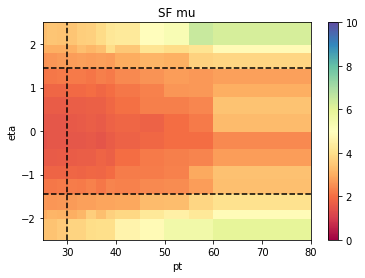

In [31]:
plt.pcolor(mybin1, mybin2, sf.T, cmap="Spectral",vmax=10,vmin=0)
plt.colorbar()
plt.xlabel("pt")
plt.ylabel("eta")
plt.axhline(1.444,color='k',linestyle="--")
plt.axhline(-1.444,color='k',linestyle="--")
plt.axvline(30,color='k',linestyle="--")
plt.title("SF "+selection)
plt.savefig("{}/SF_{}_2d.png".format(savedir,selection),dpi=300)

In [32]:
np.save("{}/SF_{}_2d".format(savedir,selection),sf)
np.save("{}/SF_std_{}_2d".format(savedir,selection),sferr)